## Package Installation and Setup

In [1]:
!pip install xgboost
!pip install mlflow
!pip install dagshub
!pip install joblib
!pip install optuna
!pip install scikit-learn
!pip install shap
!pip install optuna-integration[xgboost]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Mount Google Drive and Change Directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ML-Final')

Mounted at /content/drive


## Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# XGBoost and ML libraries
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# MLflow and experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import dagshub
import joblib
import pickle

# Hyperparameter optimization
import optuna
from optuna.integration import XGBoostPruningCallback

# Model interpretation
import shap

## Initialize MLflow and Experiment Tracking

In [4]:
dagshub.init(repo_owner='egval20', repo_name='ML-Final', mlflow=True)
mlflow.set_experiment("XGBoost_Training")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=fc6d4dc9-a30c-426a-ab86-c5eec3b28013&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=a72aedb7f022a1d2244c19a92fbbd9e3c3c826252eeaa878d30eabefcafa1787




Accessing as lagorg22

Initialized MLflow to track repo "egval20/ML-Final"

Repository egval20/ML-Final initialized!

<Experiment: artifact_location='mlflow-artifacts:/7118789c227b43a3a4ca0cc5e04d3461', creation_time=1751804285904, experiment_id='3', last_update_time=1751804285904, lifecycle_stage='active', name='XGBoost_Training', tags={}>

## Load Data and Preprocessing Pipeline

In [5]:
def get_model_ready_data(pipeline_path='preprocessing_pipeline.pkl'):
    """Load preprocessing pipeline and return preprocessing function"""
    pipeline = joblib.load(pipeline_path)
    def preprocess_for_model(raw_data):
        return pipeline.transform(raw_data)
    return preprocess_for_model, pipeline

# Load preprocessing pipeline
preprocess_fn, loaded_pipeline = get_model_ready_data()

# Load raw data
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

print(f"Train shape: {train_raw.shape}")
print(f"Test shape: {test_raw.shape}")
print(f"Date range - Train: {train_raw['Date'].min()} to {train_raw['Date'].max()}")
print(f"Date range - Test: {test_raw['Date'].min()} to {test_raw['Date'].max()}")

Train shape: (421570, 5)
Test shape: (115064, 4)
Date range - Train: 2010-02-05 to 2012-10-26
Date range - Test: 2012-11-02 to 2013-07-26


## Apply Preprocessing Pipeline

In [6]:
# Apply preprocessing
train_processed = preprocess_fn(train_raw)
test_processed = preprocess_fn(test_raw)

# Drop the original 'Size_Bin' column after encoding
train_processed = train_processed.drop('Size_Bin', axis=1)
test_processed = test_processed.drop('Size_Bin', axis=1)

# One-hot encode the 'Type' column
train_processed = pd.get_dummies(train_processed, columns=['Type'], prefix='Store_Type')
test_processed = pd.get_dummies(test_processed, columns=['Type'], prefix='Store_Type')


# Prepare features and target
# Update feature names to include the new one-hot encoded columns and exclude dropped ones
feature_names = [col for col in train_processed.columns if col not in ['Date', 'Weekly_Sales']]
X_train = train_processed[feature_names]
y_train = train_processed['Weekly_Sales']
X_test = test_processed[feature_names]


print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Target shape: {y_train.shape}")

# Check for missing values
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")

Training features shape: (421570, 63)
Test features shape: (115064, 63)
Target shape: (421570,)

Missing values in X_train: 249300
Missing values in X_test: 1380768


## Exploratory Data Analysis

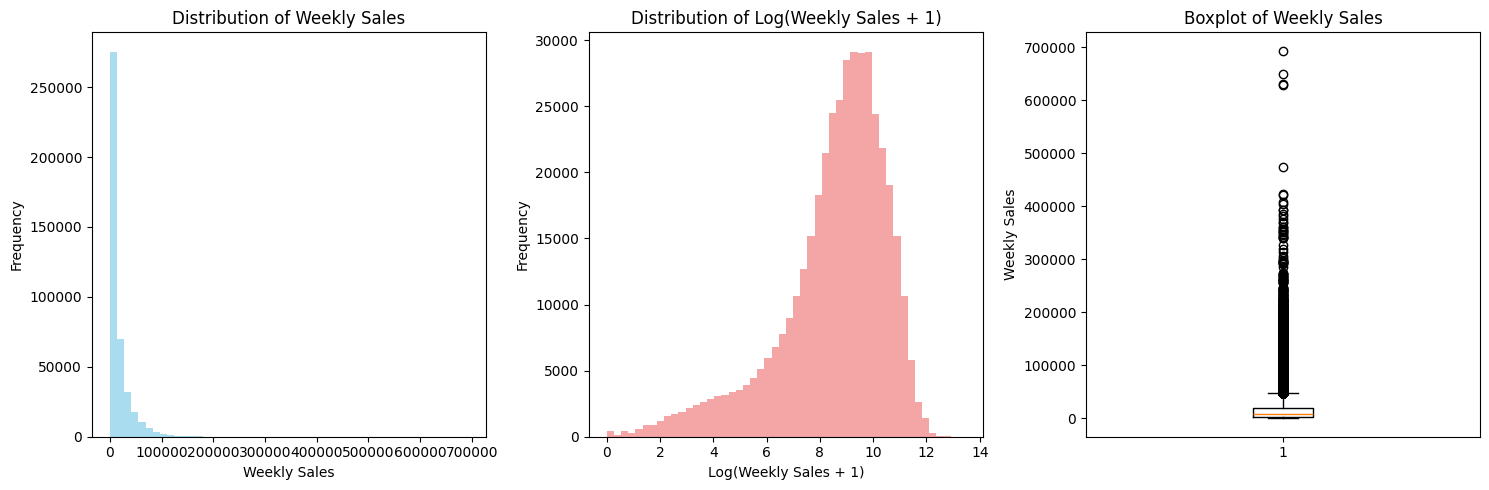


Target Statistics:
Mean: 15981.68
Std: 22710.89
Min: 0.00
Max: 693099.36
Median: 7612.03


In [7]:
# Target distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(np.log1p(y_train), bins=50, alpha=0.7, color='lightcoral')
plt.title('Distribution of Log(Weekly Sales + 1)')
plt.xlabel('Log(Weekly Sales + 1)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.boxplot(y_train)
plt.title('Boxplot of Weekly Sales')
plt.ylabel('Weekly Sales')

plt.tight_layout()
plt.show()

# Basic statistics
print(f"\nTarget Statistics:")
print(f"Mean: {y_train.mean():.2f}")
print(f"Std: {y_train.std():.2f}")
print(f"Min: {y_train.min():.2f}")
print(f"Max: {y_train.max():.2f}")
print(f"Median: {y_train.median():.2f}")

## Initial Feature Importance Analysis

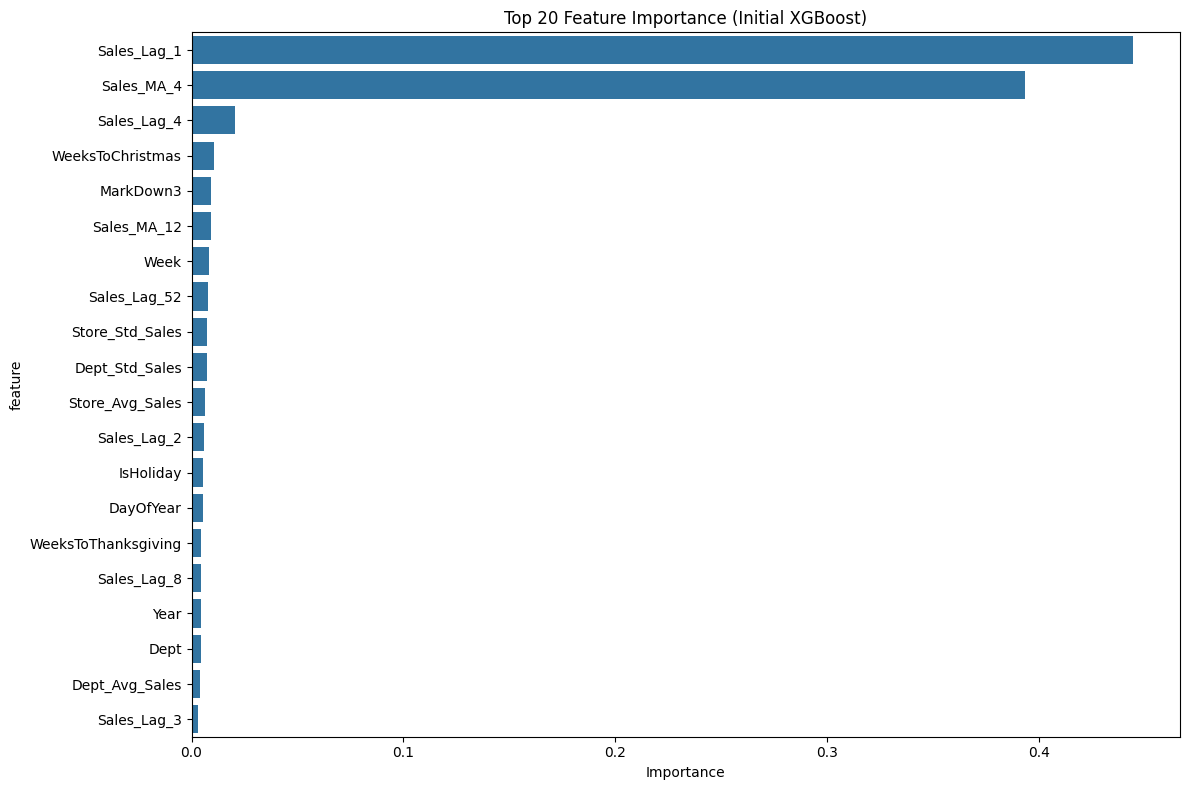

Top 10 most important features:
             feature  importance
28       Sales_Lag_1    0.444336
34        Sales_MA_4    0.393410
31       Sales_Lag_4    0.020577
24  WeeksToChristmas    0.010572
6          MarkDown3    0.009347
38       Sales_MA_12    0.008993
15              Week    0.008444
33      Sales_Lag_52    0.007833
44   Store_Std_Sales    0.007310
47    Dept_Std_Sales    0.007113


In [8]:
# Quick XGBoost to check feature importance
quick_xgb = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

quick_xgb.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': quick_xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance (Initial XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(feature_importance.head(10))

## Custom WMAE Metric Implementation

In [9]:
def wmae(y_true, y_pred, weights):
    """
    Calculate Weighted Mean Absolute Error (WMAE)

    Parameters:
    y_true: actual values
    y_pred: predicted values
    weights: weights for each prediction (5 for holiday weeks, 1 for non-holiday)
    """
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

def create_weights(data, date_col='Date', holiday_col='IsHoliday'):
    """Create weights for WMAE calculation"""
    if isinstance(data, pd.DataFrame):
        weights = np.where(data[holiday_col] == 1, 5, 1)
    else:
        # If we don't have holiday info, use uniform weights
        weights = np.ones(len(data))
    return weights

# Create weights for training data
train_weights = create_weights(train_processed)
print(f"Training weights - Holiday weeks: {(train_weights == 5).sum()}, Normal weeks: {(train_weights == 1).sum()}")

Training weights - Holiday weeks: 29661, Normal weeks: 391909


## Custom XGBoost Objective for WMAE

In [10]:
def wmae_objective(y_pred, y_true, weights):
    """Custom objective function for WMAE"""
    grad = weights * np.sign(y_pred - y_true.get_label())
    hess = weights * 0.1  # Small constant for numerical stability
    return grad, hess

def wmae_eval(y_pred, y_true, weights):
    """Custom evaluation function for WMAE"""
    error = wmae(y_true.get_label(), y_pred, weights)
    return 'wmae', error

## Time Series Cross-Validation Setup

In [11]:
class TimeSeriesValidator:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        self.tscv = TimeSeriesSplit(n_splits=n_splits)

    def validate_model(self, model, X, y, weights=None, scoring='neg_mean_absolute_error'):
        """Perform time series cross-validation"""
        cv_scores = []
        wmae_scores = []

        for train_idx, val_idx in self.tscv.split(X):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

            if weights is not None:
                weights_train = weights[train_idx]
                weights_val = weights[val_idx]
            else:
                weights_val = np.ones(len(y_val_cv))

            # Fit model
            model.fit(X_train_cv, y_train_cv)

            # Predict
            y_pred_cv = model.predict(X_val_cv)

            # Calculate metrics
            mae = mean_absolute_error(y_val_cv, y_pred_cv)
            wmae_score = wmae(y_val_cv, y_pred_cv, weights_val)

            cv_scores.append(mae)
            wmae_scores.append(wmae_score)

        return {
            'cv_mae_scores': cv_scores,
            'cv_wmae_scores': wmae_scores,
            'mean_mae': np.mean(cv_scores),
            'std_mae': np.std(cv_scores),
            'mean_wmae': np.mean(wmae_scores),
            'std_wmae': np.std(wmae_scores)
        }

ts_validator = TimeSeriesValidator(n_splits=5)

## Baseline XGBoost Model

In [12]:
with mlflow.start_run(run_name="XGBoost_Baseline"):
    # Baseline XGBoost parameters
    baseline_params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1,
        'reg_alpha': 0,
        'reg_lambda': 1
    }

    # Log parameters
    mlflow.log_params(baseline_params)

    # Create and train model
    baseline_model = xgb.XGBRegressor(**baseline_params)

    # Perform cross-validation
    cv_results = ts_validator.validate_model(baseline_model, X_train, y_train, train_weights)

    # Log cross-validation results
    mlflow.log_metrics({
        'cv_mae_mean': cv_results['mean_mae'],
        'cv_mae_std': cv_results['std_mae'],
        'cv_wmae_mean': cv_results['mean_wmae'],
        'cv_wmae_std': cv_results['std_wmae']
    })

    # Train final model on full dataset
    baseline_model.fit(X_train, y_train)

    # Make predictions
    y_pred_baseline = baseline_model.predict(X_train)

    # Calculate final metrics
    train_mae = mean_absolute_error(y_train, y_pred_baseline)
    train_wmae = wmae(y_train, y_pred_baseline, train_weights)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_baseline))
    train_r2 = r2_score(y_train, y_pred_baseline)

    # Log final metrics
    mlflow.log_metrics({
        'train_mae': train_mae,
        'train_wmae': train_wmae,
        'train_rmse': train_rmse,
        'train_r2': train_r2
    })

    # Save model
    # mlflow.xgboost.log_model(baseline_model, "baseline_model")

    print(f"Baseline XGBoost Results:")
    print(f"CV MAE: {cv_results['mean_mae']:.4f} \u00b1 {cv_results['std_mae']:.4f}")
    print(f"CV WMAE: {cv_results['mean_wmae']:.4f} \u00b1 {cv_results['std_wmae']:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train WMAE: {train_wmae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train R\u00b2: {train_r2:.4f}")

Baseline XGBoost Results:
CV MAE: 1553.5410 ± 303.1414
CV WMAE: 1748.4318 ± 356.4222
Train MAE: 1408.5183
Train WMAE: 1535.5582
Train RMSE: 3021.1191
Train R²: 0.9823
🏃 View run XGBoost_Baseline at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/3/runs/d4b183bd54bf41aea318f07bd86c7646
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/3


## Hyperparameter Optimization

In [13]:
def objective(trial):
    """Optuna objective function for hyperparameter optimization"""

    print(f"\n--- Trial {trial.number} ---")

    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'n_jobs': -1
    }

    print(f"Params: {params}")

    # Create model
    model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    **params
)

    # Perform cross-validation
    print("Validating model...")
    cv_results = ts_validator.validate_model(model, X_train, y_train, train_weights)

    print(f"Trial {trial.number} WMAE: {cv_results['mean_wmae']:.4f}")

    # Return WMAE as objective (minimize)
    return cv_results['mean_wmae']


# Run hyperparameter optimization
print("=== Starting hyperparameter optimization ===")
study = optuna.create_study(direction='minimize', study_name='xgboost_optimization')
study.optimize(objective, n_trials=50, timeout=3600)  # 1 hour timeout

# Final best results
print("\n=== Optimization Completed ===")
print(f"Best trial: {study.best_trial.number}")
print(f"Best WMAE: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")


[I 2025-07-06 20:25:51,512] A new study created in memory with name: xgboost_optimization


=== Starting hyperparameter optimization ===

--- Trial 0 ---
Params: {'n_estimators': 952, 'max_depth': 10, 'learning_rate': 0.24480354928968628, 'subsample': 0.6307158172160177, 'colsample_bytree': 0.6380903643369851, 'reg_alpha': 2.0153800946735876, 'reg_lambda': 0.8270586501028054, 'min_child_weight': 8, 'gamma': 3.4047709963459356, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:27:26,126] Trial 0 finished with value: 1896.2430248942 and parameters: {'n_estimators': 952, 'max_depth': 10, 'learning_rate': 0.24480354928968628, 'subsample': 0.6307158172160177, 'colsample_bytree': 0.6380903643369851, 'reg_alpha': 2.0153800946735876, 'reg_lambda': 0.8270586501028054, 'min_child_weight': 8, 'gamma': 3.4047709963459356}. Best is trial 0 with value: 1896.2430248942.


Trial 0 WMAE: 1896.2430

--- Trial 1 ---
Params: {'n_estimators': 391, 'max_depth': 10, 'learning_rate': 0.06695709569258027, 'subsample': 0.8361664588140485, 'colsample_bytree': 0.8893178294955449, 'reg_alpha': 4.729809287381574, 'reg_lambda': 6.979203529036409, 'min_child_weight': 9, 'gamma': 4.514881335620571, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:28:04,339] Trial 1 finished with value: 1596.3045128665249 and parameters: {'n_estimators': 391, 'max_depth': 10, 'learning_rate': 0.06695709569258027, 'subsample': 0.8361664588140485, 'colsample_bytree': 0.8893178294955449, 'reg_alpha': 4.729809287381574, 'reg_lambda': 6.979203529036409, 'min_child_weight': 9, 'gamma': 4.514881335620571}. Best is trial 1 with value: 1596.3045128665249.


Trial 1 WMAE: 1596.3045

--- Trial 2 ---
Params: {'n_estimators': 533, 'max_depth': 9, 'learning_rate': 0.2315715068389616, 'subsample': 0.8176778594295758, 'colsample_bytree': 0.8784616931479972, 'reg_alpha': 3.6015686577797954, 'reg_lambda': 4.59766364752422, 'min_child_weight': 1, 'gamma': 0.48497496735465495, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:28:56,820] Trial 2 finished with value: 1811.3528517552563 and parameters: {'n_estimators': 533, 'max_depth': 9, 'learning_rate': 0.2315715068389616, 'subsample': 0.8176778594295758, 'colsample_bytree': 0.8784616931479972, 'reg_alpha': 3.6015686577797954, 'reg_lambda': 4.59766364752422, 'min_child_weight': 1, 'gamma': 0.48497496735465495}. Best is trial 1 with value: 1596.3045128665249.


Trial 2 WMAE: 1811.3529

--- Trial 3 ---
Params: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.08662188227484399, 'subsample': 0.6794604316161389, 'colsample_bytree': 0.6711834750418552, 'reg_alpha': 6.890508716205035, 'reg_lambda': 0.504662111685491, 'min_child_weight': 1, 'gamma': 1.2594889240182472, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:29:16,762] Trial 3 finished with value: 1697.8037465796865 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.08662188227484399, 'subsample': 0.6794604316161389, 'colsample_bytree': 0.6711834750418552, 'reg_alpha': 6.890508716205035, 'reg_lambda': 0.504662111685491, 'min_child_weight': 1, 'gamma': 1.2594889240182472}. Best is trial 1 with value: 1596.3045128665249.


Trial 3 WMAE: 1697.8037

--- Trial 4 ---
Params: {'n_estimators': 525, 'max_depth': 8, 'learning_rate': 0.1460289397730232, 'subsample': 0.9384283967766899, 'colsample_bytree': 0.7531797619800579, 'reg_alpha': 1.885615454365036, 'reg_lambda': 8.470893040763979, 'min_child_weight': 8, 'gamma': 4.241258666313104, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:29:54,550] Trial 4 finished with value: 1613.620414316335 and parameters: {'n_estimators': 525, 'max_depth': 8, 'learning_rate': 0.1460289397730232, 'subsample': 0.9384283967766899, 'colsample_bytree': 0.7531797619800579, 'reg_alpha': 1.885615454365036, 'reg_lambda': 8.470893040763979, 'min_child_weight': 8, 'gamma': 4.241258666313104}. Best is trial 1 with value: 1596.3045128665249.


Trial 4 WMAE: 1613.6204

--- Trial 5 ---
Params: {'n_estimators': 804, 'max_depth': 3, 'learning_rate': 0.1818876737030544, 'subsample': 0.9123094339395311, 'colsample_bytree': 0.7351512855886001, 'reg_alpha': 5.382511478179511, 'reg_lambda': 0.4080553331475856, 'min_child_weight': 3, 'gamma': 3.778707001205067, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:30:24,310] Trial 5 finished with value: 1853.0061979200823 and parameters: {'n_estimators': 804, 'max_depth': 3, 'learning_rate': 0.1818876737030544, 'subsample': 0.9123094339395311, 'colsample_bytree': 0.7351512855886001, 'reg_alpha': 5.382511478179511, 'reg_lambda': 0.4080553331475856, 'min_child_weight': 3, 'gamma': 3.778707001205067}. Best is trial 1 with value: 1596.3045128665249.


Trial 5 WMAE: 1853.0062

--- Trial 6 ---
Params: {'n_estimators': 867, 'max_depth': 7, 'learning_rate': 0.23674705194288959, 'subsample': 0.7656885035443984, 'colsample_bytree': 0.9463095563369195, 'reg_alpha': 3.00495035282611, 'reg_lambda': 8.240798699910068, 'min_child_weight': 4, 'gamma': 3.7630535148764563, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:31:14,757] Trial 6 finished with value: 1728.6468150542617 and parameters: {'n_estimators': 867, 'max_depth': 7, 'learning_rate': 0.23674705194288959, 'subsample': 0.7656885035443984, 'colsample_bytree': 0.9463095563369195, 'reg_alpha': 3.00495035282611, 'reg_lambda': 8.240798699910068, 'min_child_weight': 4, 'gamma': 3.7630535148764563}. Best is trial 1 with value: 1596.3045128665249.


Trial 6 WMAE: 1728.6468

--- Trial 7 ---
Params: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.1775604083999028, 'subsample': 0.8026602062977599, 'colsample_bytree': 0.7253017857913124, 'reg_alpha': 2.009797450436064, 'reg_lambda': 3.3934487956213677, 'min_child_weight': 9, 'gamma': 3.753667689338771, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:31:28,941] Trial 7 finished with value: 1742.0993317250693 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.1775604083999028, 'subsample': 0.8026602062977599, 'colsample_bytree': 0.7253017857913124, 'reg_alpha': 2.009797450436064, 'reg_lambda': 3.3934487956213677, 'min_child_weight': 9, 'gamma': 3.753667689338771}. Best is trial 1 with value: 1596.3045128665249.


Trial 7 WMAE: 1742.0993

--- Trial 8 ---
Params: {'n_estimators': 775, 'max_depth': 8, 'learning_rate': 0.11186028106374797, 'subsample': 0.9107598662526065, 'colsample_bytree': 0.8451636162159677, 'reg_alpha': 2.838369557316407, 'reg_lambda': 6.467033595903092, 'min_child_weight': 10, 'gamma': 4.206549377511342, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:32:19,909] Trial 8 finished with value: 1628.2169410740871 and parameters: {'n_estimators': 775, 'max_depth': 8, 'learning_rate': 0.11186028106374797, 'subsample': 0.9107598662526065, 'colsample_bytree': 0.8451636162159677, 'reg_alpha': 2.838369557316407, 'reg_lambda': 6.467033595903092, 'min_child_weight': 10, 'gamma': 4.206549377511342}. Best is trial 1 with value: 1596.3045128665249.


Trial 8 WMAE: 1628.2169

--- Trial 9 ---
Params: {'n_estimators': 638, 'max_depth': 9, 'learning_rate': 0.27155271658010127, 'subsample': 0.9730022139910145, 'colsample_bytree': 0.6784869999446592, 'reg_alpha': 4.80449169926703, 'reg_lambda': 4.311125113128007, 'min_child_weight': 9, 'gamma': 3.0658067216731744, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:33:09,887] Trial 9 finished with value: 1715.2575584780493 and parameters: {'n_estimators': 638, 'max_depth': 9, 'learning_rate': 0.27155271658010127, 'subsample': 0.9730022139910145, 'colsample_bytree': 0.6784869999446592, 'reg_alpha': 4.80449169926703, 'reg_lambda': 4.311125113128007, 'min_child_weight': 9, 'gamma': 3.0658067216731744}. Best is trial 1 with value: 1596.3045128665249.


Trial 9 WMAE: 1715.2576

--- Trial 10 ---
Params: {'n_estimators': 342, 'max_depth': 5, 'learning_rate': 0.017719418358454357, 'subsample': 0.7191557077939712, 'colsample_bytree': 0.9840893383970433, 'reg_alpha': 9.78651142108627, 'reg_lambda': 9.920596654953238, 'min_child_weight': 6, 'gamma': 2.1586788478709438, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:33:31,387] Trial 10 finished with value: 1855.4293822162551 and parameters: {'n_estimators': 342, 'max_depth': 5, 'learning_rate': 0.017719418358454357, 'subsample': 0.7191557077939712, 'colsample_bytree': 0.9840893383970433, 'reg_alpha': 9.78651142108627, 'reg_lambda': 9.920596654953238, 'min_child_weight': 6, 'gamma': 2.1586788478709438}. Best is trial 1 with value: 1596.3045128665249.


Trial 10 WMAE: 1855.4294

--- Trial 11 ---
Params: {'n_estimators': 487, 'max_depth': 10, 'learning_rate': 0.050022963193040115, 'subsample': 0.8871513585665781, 'colsample_bytree': 0.7930821113815528, 'reg_alpha': 0.01760497261053051, 'reg_lambda': 6.91316116897186, 'min_child_weight': 7, 'gamma': 4.968634352371054, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:34:17,599] Trial 11 finished with value: 1579.2542169402252 and parameters: {'n_estimators': 487, 'max_depth': 10, 'learning_rate': 0.050022963193040115, 'subsample': 0.8871513585665781, 'colsample_bytree': 0.7930821113815528, 'reg_alpha': 0.01760497261053051, 'reg_lambda': 6.91316116897186, 'min_child_weight': 7, 'gamma': 4.968634352371054}. Best is trial 11 with value: 1579.2542169402252.


Trial 11 WMAE: 1579.2542

--- Trial 12 ---
Params: {'n_estimators': 412, 'max_depth': 10, 'learning_rate': 0.018322676825006157, 'subsample': 0.856736174570088, 'colsample_bytree': 0.8464515830819586, 'reg_alpha': 0.4078148153048584, 'reg_lambda': 6.477838024822565, 'min_child_weight': 6, 'gamma': 4.900870947645574, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:35:06,851] Trial 12 finished with value: 1607.8971890765893 and parameters: {'n_estimators': 412, 'max_depth': 10, 'learning_rate': 0.018322676825006157, 'subsample': 0.856736174570088, 'colsample_bytree': 0.8464515830819586, 'reg_alpha': 0.4078148153048584, 'reg_lambda': 6.477838024822565, 'min_child_weight': 6, 'gamma': 4.900870947645574}. Best is trial 11 with value: 1579.2542169402252.


Trial 12 WMAE: 1607.8972

--- Trial 13 ---
Params: {'n_estimators': 431, 'max_depth': 10, 'learning_rate': 0.06613999201381866, 'subsample': 0.8729237437256212, 'colsample_bytree': 0.9081024318557485, 'reg_alpha': 0.014671850317447444, 'reg_lambda': 6.752452051634471, 'min_child_weight': 7, 'gamma': 4.954688697897086, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:35:50,126] Trial 13 finished with value: 1591.1886822972456 and parameters: {'n_estimators': 431, 'max_depth': 10, 'learning_rate': 0.06613999201381866, 'subsample': 0.8729237437256212, 'colsample_bytree': 0.9081024318557485, 'reg_alpha': 0.014671850317447444, 'reg_lambda': 6.752452051634471, 'min_child_weight': 7, 'gamma': 4.954688697897086}. Best is trial 11 with value: 1579.2542169402252.


Trial 13 WMAE: 1591.1887

--- Trial 14 ---
Params: {'n_estimators': 652, 'max_depth': 9, 'learning_rate': 0.06393122517027193, 'subsample': 0.9995996675514547, 'colsample_bytree': 0.7953675627925028, 'reg_alpha': 0.031558191684957215, 'reg_lambda': 5.664625505232252, 'min_child_weight': 7, 'gamma': 4.92259462587607, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:36:41,676] Trial 14 finished with value: 1576.6951556608358 and parameters: {'n_estimators': 652, 'max_depth': 9, 'learning_rate': 0.06393122517027193, 'subsample': 0.9995996675514547, 'colsample_bytree': 0.7953675627925028, 'reg_alpha': 0.031558191684957215, 'reg_lambda': 5.664625505232252, 'min_child_weight': 7, 'gamma': 4.92259462587607}. Best is trial 14 with value: 1576.6951556608358.


Trial 14 WMAE: 1576.6952

--- Trial 15 ---
Params: {'n_estimators': 632, 'max_depth': 9, 'learning_rate': 0.046709550104402114, 'subsample': 0.9812541787793592, 'colsample_bytree': 0.7997290094220338, 'reg_alpha': 0.785893190328246, 'reg_lambda': 2.7935681511122974, 'min_child_weight': 4, 'gamma': 2.0405366582945894, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:37:35,212] Trial 15 finished with value: 1601.4056576189328 and parameters: {'n_estimators': 632, 'max_depth': 9, 'learning_rate': 0.046709550104402114, 'subsample': 0.9812541787793592, 'colsample_bytree': 0.7997290094220338, 'reg_alpha': 0.785893190328246, 'reg_lambda': 2.7935681511122974, 'min_child_weight': 4, 'gamma': 2.0405366582945894}. Best is trial 14 with value: 1576.6951556608358.


Trial 15 WMAE: 1601.4057

--- Trial 16 ---
Params: {'n_estimators': 686, 'max_depth': 8, 'learning_rate': 0.1143793303409758, 'subsample': 0.9965967901710147, 'colsample_bytree': 0.7925264307149933, 'reg_alpha': 8.021682631275644, 'reg_lambda': 5.5343548912415885, 'min_child_weight': 5, 'gamma': 2.822404662071625, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:38:21,940] Trial 16 finished with value: 1612.0828262496534 and parameters: {'n_estimators': 686, 'max_depth': 8, 'learning_rate': 0.1143793303409758, 'subsample': 0.9965967901710147, 'colsample_bytree': 0.7925264307149933, 'reg_alpha': 8.021682631275644, 'reg_lambda': 5.5343548912415885, 'min_child_weight': 5, 'gamma': 2.822404662071625}. Best is trial 14 with value: 1576.6951556608358.


Trial 16 WMAE: 1612.0828

--- Trial 17 ---
Params: {'n_estimators': 701, 'max_depth': 4, 'learning_rate': 0.11779904824942651, 'subsample': 0.9264351178475047, 'colsample_bytree': 0.7602524112857831, 'reg_alpha': 1.0948999452932617, 'reg_lambda': 8.22002407160797, 'min_child_weight': 7, 'gamma': 4.923667064040099, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:38:50,282] Trial 17 finished with value: 1748.8777973075612 and parameters: {'n_estimators': 701, 'max_depth': 4, 'learning_rate': 0.11779904824942651, 'subsample': 0.9264351178475047, 'colsample_bytree': 0.7602524112857831, 'reg_alpha': 1.0948999452932617, 'reg_lambda': 8.22002407160797, 'min_child_weight': 7, 'gamma': 4.923667064040099}. Best is trial 14 with value: 1576.6951556608358.


Trial 17 WMAE: 1748.8778

--- Trial 18 ---
Params: {'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.04460904688513504, 'subsample': 0.8836257702579928, 'colsample_bytree': 0.8317493592796223, 'reg_alpha': 1.25587390938342, 'reg_lambda': 5.4676843023425405, 'min_child_weight': 7, 'gamma': 0.1500872606068966, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:39:10,895] Trial 18 finished with value: 1705.6178814412924 and parameters: {'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.04460904688513504, 'subsample': 0.8836257702579928, 'colsample_bytree': 0.8317493592796223, 'reg_alpha': 1.25587390938342, 'reg_lambda': 5.4676843023425405, 'min_child_weight': 7, 'gamma': 0.1500872606068966}. Best is trial 14 with value: 1576.6951556608358.


Trial 18 WMAE: 1705.6179

--- Trial 19 ---
Params: {'n_estimators': 515, 'max_depth': 9, 'learning_rate': 0.08947473425790312, 'subsample': 0.9534566124236333, 'colsample_bytree': 0.607926676722141, 'reg_alpha': 0.06976666543462488, 'reg_lambda': 2.195466871985623, 'min_child_weight': 5, 'gamma': 1.5699527803983448, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:39:54,715] Trial 19 finished with value: 1619.5541992522785 and parameters: {'n_estimators': 515, 'max_depth': 9, 'learning_rate': 0.08947473425790312, 'subsample': 0.9534566124236333, 'colsample_bytree': 0.607926676722141, 'reg_alpha': 0.06976666543462488, 'reg_lambda': 2.195466871985623, 'min_child_weight': 5, 'gamma': 1.5699527803983448}. Best is trial 14 with value: 1576.6951556608358.


Trial 19 WMAE: 1619.5542

--- Trial 20 ---
Params: {'n_estimators': 990, 'max_depth': 8, 'learning_rate': 0.14597027072566085, 'subsample': 0.7677745109012566, 'colsample_bytree': 0.7028605680190085, 'reg_alpha': 3.714280448901378, 'reg_lambda': 9.679826797944752, 'min_child_weight': 3, 'gamma': 4.392044283345986, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:40:58,361] Trial 20 finished with value: 1607.3440907418353 and parameters: {'n_estimators': 990, 'max_depth': 8, 'learning_rate': 0.14597027072566085, 'subsample': 0.7677745109012566, 'colsample_bytree': 0.7028605680190085, 'reg_alpha': 3.714280448901378, 'reg_lambda': 9.679826797944752, 'min_child_weight': 3, 'gamma': 4.392044283345986}. Best is trial 14 with value: 1576.6951556608358.


Trial 20 WMAE: 1607.3441

--- Trial 21 ---
Params: {'n_estimators': 448, 'max_depth': 10, 'learning_rate': 0.055301142987168206, 'subsample': 0.8731937708495612, 'colsample_bytree': 0.9257947202786027, 'reg_alpha': 0.13051970872617055, 'reg_lambda': 7.480310536847789, 'min_child_weight': 7, 'gamma': 4.987755799541693, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:41:42,658] Trial 21 finished with value: 1580.5233048695507 and parameters: {'n_estimators': 448, 'max_depth': 10, 'learning_rate': 0.055301142987168206, 'subsample': 0.8731937708495612, 'colsample_bytree': 0.9257947202786027, 'reg_alpha': 0.13051970872617055, 'reg_lambda': 7.480310536847789, 'min_child_weight': 7, 'gamma': 4.987755799541693}. Best is trial 14 with value: 1576.6951556608358.


Trial 21 WMAE: 1580.5233

--- Trial 22 ---
Params: {'n_estimators': 608, 'max_depth': 10, 'learning_rate': 0.033767781141931894, 'subsample': 0.8929236092715608, 'colsample_bytree': 0.78988786946375, 'reg_alpha': 1.2581865171896078, 'reg_lambda': 7.492046551549315, 'min_child_weight': 8, 'gamma': 4.559934949546096, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:42:36,749] Trial 22 finished with value: 1574.1011042423302 and parameters: {'n_estimators': 608, 'max_depth': 10, 'learning_rate': 0.033767781141931894, 'subsample': 0.8929236092715608, 'colsample_bytree': 0.78988786946375, 'reg_alpha': 1.2581865171896078, 'reg_lambda': 7.492046551549315, 'min_child_weight': 8, 'gamma': 4.559934949546096}. Best is trial 22 with value: 1574.1011042423302.


Trial 22 WMAE: 1574.1011

--- Trial 23 ---
Params: {'n_estimators': 611, 'max_depth': 9, 'learning_rate': 0.014161339437410797, 'subsample': 0.9012680538849327, 'colsample_bytree': 0.7822427088496016, 'reg_alpha': 1.610019211728455, 'reg_lambda': 5.762348495696326, 'min_child_weight': 8, 'gamma': 4.479729168164232, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:43:29,911] Trial 23 finished with value: 1615.195087442587 and parameters: {'n_estimators': 611, 'max_depth': 9, 'learning_rate': 0.014161339437410797, 'subsample': 0.9012680538849327, 'colsample_bytree': 0.7822427088496016, 'reg_alpha': 1.610019211728455, 'reg_lambda': 5.762348495696326, 'min_child_weight': 8, 'gamma': 4.479729168164232}. Best is trial 22 with value: 1574.1011042423302.


Trial 23 WMAE: 1615.1951

--- Trial 24 ---
Params: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.03839075698833554, 'subsample': 0.8423718706645835, 'colsample_bytree': 0.8161649318284956, 'reg_alpha': 1.270453329678787, 'reg_lambda': 7.533594526283917, 'min_child_weight': 10, 'gamma': 4.030400710793146, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:44:33,374] Trial 24 finished with value: 1573.7621822474189 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.03839075698833554, 'subsample': 0.8423718706645835, 'colsample_bytree': 0.8161649318284956, 'reg_alpha': 1.270453329678787, 'reg_lambda': 7.533594526283917, 'min_child_weight': 10, 'gamma': 4.030400710793146}. Best is trial 24 with value: 1573.7621822474189.


Trial 24 WMAE: 1573.7622

--- Trial 25 ---
Params: {'n_estimators': 764, 'max_depth': 9, 'learning_rate': 0.09190000260556405, 'subsample': 0.7750609825046311, 'colsample_bytree': 0.8296378474678661, 'reg_alpha': 2.3814511928437287, 'reg_lambda': 8.828828966604421, 'min_child_weight': 10, 'gamma': 3.3391162839322606, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:45:27,852] Trial 25 finished with value: 1598.5593731302652 and parameters: {'n_estimators': 764, 'max_depth': 9, 'learning_rate': 0.09190000260556405, 'subsample': 0.7750609825046311, 'colsample_bytree': 0.8296378474678661, 'reg_alpha': 2.3814511928437287, 'reg_lambda': 8.828828966604421, 'min_child_weight': 10, 'gamma': 3.3391162839322606}. Best is trial 24 with value: 1573.7621822474189.


Trial 25 WMAE: 1598.5594

--- Trial 26 ---
Params: {'n_estimators': 589, 'max_depth': 7, 'learning_rate': 0.030078503787830245, 'subsample': 0.8364017098380856, 'colsample_bytree': 0.872177670406645, 'reg_alpha': 1.094415053048203, 'reg_lambda': 7.418829293871044, 'min_child_weight': 9, 'gamma': 4.044204255137304, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:46:03,189] Trial 26 finished with value: 1639.425032207392 and parameters: {'n_estimators': 589, 'max_depth': 7, 'learning_rate': 0.030078503787830245, 'subsample': 0.8364017098380856, 'colsample_bytree': 0.872177670406645, 'reg_alpha': 1.094415053048203, 'reg_lambda': 7.418829293871044, 'min_child_weight': 9, 'gamma': 4.044204255137304}. Best is trial 24 with value: 1573.7621822474189.


Trial 26 WMAE: 1639.4250

--- Trial 27 ---
Params: {'n_estimators': 865, 'max_depth': 10, 'learning_rate': 0.07617016604702934, 'subsample': 0.7365727489409308, 'colsample_bytree': 0.8187021928259994, 'reg_alpha': 3.610200661380353, 'reg_lambda': 3.99443498097521, 'min_child_weight': 10, 'gamma': 4.563400555086231, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:47:15,886] Trial 27 finished with value: 1604.4018954763683 and parameters: {'n_estimators': 865, 'max_depth': 10, 'learning_rate': 0.07617016604702934, 'subsample': 0.7365727489409308, 'colsample_bytree': 0.8187021928259994, 'reg_alpha': 3.610200661380353, 'reg_lambda': 3.99443498097521, 'min_child_weight': 10, 'gamma': 4.563400555086231}. Best is trial 24 with value: 1573.7621822474189.


Trial 27 WMAE: 1604.4019

--- Trial 28 ---
Params: {'n_estimators': 726, 'max_depth': 8, 'learning_rate': 0.033839221315431225, 'subsample': 0.9572330415277394, 'colsample_bytree': 0.7620898284535307, 'reg_alpha': 2.7399573751959374, 'reg_lambda': 8.979414555863608, 'min_child_weight': 8, 'gamma': 3.9729862845163972, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:48:03,229] Trial 28 finished with value: 1585.7735008456712 and parameters: {'n_estimators': 726, 'max_depth': 8, 'learning_rate': 0.033839221315431225, 'subsample': 0.9572330415277394, 'colsample_bytree': 0.7620898284535307, 'reg_alpha': 2.7399573751959374, 'reg_lambda': 8.979414555863608, 'min_child_weight': 8, 'gamma': 3.9729862845163972}. Best is trial 24 with value: 1573.7621822474189.


Trial 28 WMAE: 1585.7735

--- Trial 29 ---
Params: {'n_estimators': 864, 'max_depth': 9, 'learning_rate': 0.010969169339513935, 'subsample': 0.6817131859468545, 'colsample_bytree': 0.8589147556705785, 'reg_alpha': 5.565502962797216, 'reg_lambda': 7.665923583678207, 'min_child_weight': 8, 'gamma': 3.42976346850043, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:49:12,619] Trial 29 finished with value: 1615.6820280358424 and parameters: {'n_estimators': 864, 'max_depth': 9, 'learning_rate': 0.010969169339513935, 'subsample': 0.6817131859468545, 'colsample_bytree': 0.8589147556705785, 'reg_alpha': 5.565502962797216, 'reg_lambda': 7.665923583678207, 'min_child_weight': 8, 'gamma': 3.42976346850043}. Best is trial 24 with value: 1573.7621822474189.


Trial 29 WMAE: 1615.6820

--- Trial 30 ---
Params: {'n_estimators': 930, 'max_depth': 10, 'learning_rate': 0.10624648647391098, 'subsample': 0.8459320444161519, 'colsample_bytree': 0.7238591208126408, 'reg_alpha': 1.3918232757694202, 'reg_lambda': 5.86029204762634, 'min_child_weight': 10, 'gamma': 2.7032195077835213, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:50:33,651] Trial 30 finished with value: 1602.2355636902191 and parameters: {'n_estimators': 930, 'max_depth': 10, 'learning_rate': 0.10624648647391098, 'subsample': 0.8459320444161519, 'colsample_bytree': 0.7238591208126408, 'reg_alpha': 1.3918232757694202, 'reg_lambda': 5.86029204762634, 'min_child_weight': 10, 'gamma': 2.7032195077835213}. Best is trial 24 with value: 1573.7621822474189.


Trial 30 WMAE: 1602.2356

--- Trial 31 ---
Params: {'n_estimators': 476, 'max_depth': 10, 'learning_rate': 0.05368733954441479, 'subsample': 0.8890425847832576, 'colsample_bytree': 0.8037452688567189, 'reg_alpha': 0.7689984544577768, 'reg_lambda': 6.212924979639509, 'min_child_weight': 6, 'gamma': 4.703838834626508, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:51:21,985] Trial 31 finished with value: 1567.3318611061727 and parameters: {'n_estimators': 476, 'max_depth': 10, 'learning_rate': 0.05368733954441479, 'subsample': 0.8890425847832576, 'colsample_bytree': 0.8037452688567189, 'reg_alpha': 0.7689984544577768, 'reg_lambda': 6.212924979639509, 'min_child_weight': 6, 'gamma': 4.703838834626508}. Best is trial 31 with value: 1567.3318611061727.


Trial 31 WMAE: 1567.3319

--- Trial 32 ---
Params: {'n_estimators': 574, 'max_depth': 10, 'learning_rate': 0.06251822613257572, 'subsample': 0.6037322202666, 'colsample_bytree': 0.814335489833334, 'reg_alpha': 0.642445558895728, 'reg_lambda': 4.921308429262197, 'min_child_weight': 9, 'gamma': 4.480392866669909, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:52:11,513] Trial 32 finished with value: 1604.3252950182393 and parameters: {'n_estimators': 574, 'max_depth': 10, 'learning_rate': 0.06251822613257572, 'subsample': 0.6037322202666, 'colsample_bytree': 0.814335489833334, 'reg_alpha': 0.642445558895728, 'reg_lambda': 4.921308429262197, 'min_child_weight': 9, 'gamma': 4.480392866669909}. Best is trial 31 with value: 1567.3318611061727.


Trial 32 WMAE: 1604.3253

--- Trial 33 ---
Params: {'n_estimators': 685, 'max_depth': 9, 'learning_rate': 0.032153084669088006, 'subsample': 0.8104903705894124, 'colsample_bytree': 0.768233289249743, 'reg_alpha': 1.7086987001512042, 'reg_lambda': 6.2184162236324605, 'min_child_weight': 6, 'gamma': 4.630581581896089, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:53:07,715] Trial 33 finished with value: 1578.2119387114356 and parameters: {'n_estimators': 685, 'max_depth': 9, 'learning_rate': 0.032153084669088006, 'subsample': 0.8104903705894124, 'colsample_bytree': 0.768233289249743, 'reg_alpha': 1.7086987001512042, 'reg_lambda': 6.2184162236324605, 'min_child_weight': 6, 'gamma': 4.630581581896089}. Best is trial 31 with value: 1567.3318611061727.


Trial 33 WMAE: 1578.2119

--- Trial 34 ---
Params: {'n_estimators': 364, 'max_depth': 10, 'learning_rate': 0.07520675335016397, 'subsample': 0.8306854011290354, 'colsample_bytree': 0.897674167958848, 'reg_alpha': 0.7839723692065803, 'reg_lambda': 7.580541526521027, 'min_child_weight': 6, 'gamma': 4.678541933270267, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:53:46,190] Trial 34 finished with value: 1583.4562834359049 and parameters: {'n_estimators': 364, 'max_depth': 10, 'learning_rate': 0.07520675335016397, 'subsample': 0.8306854011290354, 'colsample_bytree': 0.897674167958848, 'reg_alpha': 0.7839723692065803, 'reg_lambda': 7.580541526521027, 'min_child_weight': 6, 'gamma': 4.678541933270267}. Best is trial 31 with value: 1567.3318611061727.


Trial 34 WMAE: 1583.4563

--- Trial 35 ---
Params: {'n_estimators': 657, 'max_depth': 9, 'learning_rate': 0.1296513716448378, 'subsample': 0.9335223047861094, 'colsample_bytree': 0.812306599954594, 'reg_alpha': 2.2720789669383956, 'reg_lambda': 5.169561743455471, 'min_child_weight': 8, 'gamma': 3.510281090444521, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:54:38,681] Trial 35 finished with value: 1612.9534215550962 and parameters: {'n_estimators': 657, 'max_depth': 9, 'learning_rate': 0.1296513716448378, 'subsample': 0.9335223047861094, 'colsample_bytree': 0.812306599954594, 'reg_alpha': 2.2720789669383956, 'reg_lambda': 5.169561743455471, 'min_child_weight': 8, 'gamma': 3.510281090444521}. Best is trial 31 with value: 1567.3318611061727.


Trial 35 WMAE: 1612.9534

--- Trial 36 ---
Params: {'n_estimators': 571, 'max_depth': 10, 'learning_rate': 0.20080981385519642, 'subsample': 0.8640710986536964, 'colsample_bytree': 0.7412006927776915, 'reg_alpha': 6.6282420037359415, 'reg_lambda': 7.151357210976537, 'min_child_weight': 5, 'gamma': 4.013798383734169, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:55:39,785] Trial 36 finished with value: 1655.2097897021129 and parameters: {'n_estimators': 571, 'max_depth': 10, 'learning_rate': 0.20080981385519642, 'subsample': 0.8640710986536964, 'colsample_bytree': 0.7412006927776915, 'reg_alpha': 6.6282420037359415, 'reg_lambda': 7.151357210976537, 'min_child_weight': 5, 'gamma': 4.013798383734169}. Best is trial 31 with value: 1567.3318611061727.


Trial 36 WMAE: 1655.2098

--- Trial 37 ---
Params: {'n_estimators': 742, 'max_depth': 8, 'learning_rate': 0.03443744495236391, 'subsample': 0.8967733750190104, 'colsample_bytree': 0.7009800883678395, 'reg_alpha': 3.9865079812989688, 'reg_lambda': 6.091394021859803, 'min_child_weight': 9, 'gamma': 4.185141054958829, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:56:25,878] Trial 37 finished with value: 1594.5301017816487 and parameters: {'n_estimators': 742, 'max_depth': 8, 'learning_rate': 0.03443744495236391, 'subsample': 0.8967733750190104, 'colsample_bytree': 0.7009800883678395, 'reg_alpha': 3.9865079812989688, 'reg_lambda': 6.091394021859803, 'min_child_weight': 9, 'gamma': 4.185141054958829}. Best is trial 31 with value: 1567.3318611061727.


Trial 37 WMAE: 1594.5301

--- Trial 38 ---
Params: {'n_estimators': 811, 'max_depth': 10, 'learning_rate': 0.2972973850613104, 'subsample': 0.7912790341659347, 'colsample_bytree': 0.870618750926266, 'reg_alpha': 3.1988298079352417, 'reg_lambda': 1.3657768222684563, 'min_child_weight': 8, 'gamma': 4.659843987828335, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:57:51,644] Trial 38 finished with value: 1897.3748735414192 and parameters: {'n_estimators': 811, 'max_depth': 10, 'learning_rate': 0.2972973850613104, 'subsample': 0.7912790341659347, 'colsample_bytree': 0.870618750926266, 'reg_alpha': 3.1988298079352417, 'reg_lambda': 1.3657768222684563, 'min_child_weight': 8, 'gamma': 4.659843987828335}. Best is trial 31 with value: 1567.3318611061727.


Trial 38 WMAE: 1897.3749

--- Trial 39 ---
Params: {'n_estimators': 490, 'max_depth': 9, 'learning_rate': 0.09211874995022612, 'subsample': 0.9517669608764971, 'colsample_bytree': 0.7766257265433587, 'reg_alpha': 4.3020734920542, 'reg_lambda': 8.13322124285784, 'min_child_weight': 4, 'gamma': 3.6897947580754558, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:58:33,485] Trial 39 finished with value: 1590.3461593747509 and parameters: {'n_estimators': 490, 'max_depth': 9, 'learning_rate': 0.09211874995022612, 'subsample': 0.9517669608764971, 'colsample_bytree': 0.7766257265433587, 'reg_alpha': 4.3020734920542, 'reg_lambda': 8.13322124285784, 'min_child_weight': 4, 'gamma': 3.6897947580754558}. Best is trial 31 with value: 1567.3318611061727.


Trial 39 WMAE: 1590.3462

--- Trial 40 ---
Params: {'n_estimators': 549, 'max_depth': 3, 'learning_rate': 0.07552847285516795, 'subsample': 0.9146973182431231, 'colsample_bytree': 0.8493281226757252, 'reg_alpha': 1.9477641755644788, 'reg_lambda': 4.735056110345152, 'min_child_weight': 7, 'gamma': 0.9492089027554296, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:58:55,349] Trial 40 finished with value: 1892.8568579419436 and parameters: {'n_estimators': 549, 'max_depth': 3, 'learning_rate': 0.07552847285516795, 'subsample': 0.9146973182431231, 'colsample_bytree': 0.8493281226757252, 'reg_alpha': 1.9477641755644788, 'reg_lambda': 4.735056110345152, 'min_child_weight': 7, 'gamma': 0.9492089027554296}. Best is trial 31 with value: 1567.3318611061727.


Trial 40 WMAE: 1892.8569

--- Trial 41 ---
Params: {'n_estimators': 691, 'max_depth': 9, 'learning_rate': 0.031926597478884634, 'subsample': 0.8063465265562538, 'colsample_bytree': 0.77617283009052, 'reg_alpha': 1.5398604533126077, 'reg_lambda': 6.301275174654371, 'min_child_weight': 6, 'gamma': 4.723239163637864, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 20:59:48,130] Trial 41 finished with value: 1578.4443702818612 and parameters: {'n_estimators': 691, 'max_depth': 9, 'learning_rate': 0.031926597478884634, 'subsample': 0.8063465265562538, 'colsample_bytree': 0.77617283009052, 'reg_alpha': 1.5398604533126077, 'reg_lambda': 6.301275174654371, 'min_child_weight': 6, 'gamma': 4.723239163637864}. Best is trial 31 with value: 1567.3318611061727.


Trial 41 WMAE: 1578.4444

--- Trial 42 ---
Params: {'n_estimators': 635, 'max_depth': 9, 'learning_rate': 0.04433323638641678, 'subsample': 0.8129760106697459, 'colsample_bytree': 0.7479005811039195, 'reg_alpha': 0.8166963989473266, 'reg_lambda': 6.794826216732865, 'min_child_weight': 6, 'gamma': 4.284172438929543, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:00:36,632] Trial 42 finished with value: 1582.3407235301697 and parameters: {'n_estimators': 635, 'max_depth': 9, 'learning_rate': 0.04433323638641678, 'subsample': 0.8129760106697459, 'colsample_bytree': 0.7479005811039195, 'reg_alpha': 0.8166963989473266, 'reg_lambda': 6.794826216732865, 'min_child_weight': 6, 'gamma': 4.284172438929543}. Best is trial 31 with value: 1567.3318611061727.


Trial 42 WMAE: 1582.3407

--- Trial 43 ---
Params: {'n_estimators': 828, 'max_depth': 10, 'learning_rate': 0.06309945549831628, 'subsample': 0.8275877624804029, 'colsample_bytree': 0.7643581917498986, 'reg_alpha': 1.8189507980586874, 'reg_lambda': 3.894374862704878, 'min_child_weight': 5, 'gamma': 4.379267885074191, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:01:56,960] Trial 43 finished with value: 1579.4526015247407 and parameters: {'n_estimators': 828, 'max_depth': 10, 'learning_rate': 0.06309945549831628, 'subsample': 0.8275877624804029, 'colsample_bytree': 0.7643581917498986, 'reg_alpha': 1.8189507980586874, 'reg_lambda': 3.894374862704878, 'min_child_weight': 5, 'gamma': 4.379267885074191}. Best is trial 31 with value: 1567.3318611061727.


Trial 43 WMAE: 1579.4526

--- Trial 44 ---
Params: {'n_estimators': 665, 'max_depth': 8, 'learning_rate': 0.02891334348137453, 'subsample': 0.7401289730511771, 'colsample_bytree': 0.8079297425560719, 'reg_alpha': 2.5512908743740343, 'reg_lambda': 6.246879715539415, 'min_child_weight': 6, 'gamma': 4.658903306112578, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:02:42,770] Trial 44 finished with value: 1603.5736331455641 and parameters: {'n_estimators': 665, 'max_depth': 8, 'learning_rate': 0.02891334348137453, 'subsample': 0.7401289730511771, 'colsample_bytree': 0.8079297425560719, 'reg_alpha': 2.5512908743740343, 'reg_lambda': 6.246879715539415, 'min_child_weight': 6, 'gamma': 4.658903306112578}. Best is trial 31 with value: 1567.3318611061727.


Trial 44 WMAE: 1603.5736

--- Trial 45 ---
Params: {'n_estimators': 726, 'max_depth': 10, 'learning_rate': 0.05341944636599279, 'subsample': 0.850499503652351, 'colsample_bytree': 0.707912646703435, 'reg_alpha': 0.6013880104627639, 'reg_lambda': 5.319866674119858, 'min_child_weight': 7, 'gamma': 3.9939223971258575, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:03:47,537] Trial 45 finished with value: 1566.477017783633 and parameters: {'n_estimators': 726, 'max_depth': 10, 'learning_rate': 0.05341944636599279, 'subsample': 0.850499503652351, 'colsample_bytree': 0.707912646703435, 'reg_alpha': 0.6013880104627639, 'reg_lambda': 5.319866674119858, 'min_child_weight': 7, 'gamma': 3.9939223971258575}. Best is trial 45 with value: 1566.477017783633.


Trial 45 WMAE: 1566.4770

--- Trial 46 ---
Params: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.054151283475118786, 'subsample': 0.8508906557730747, 'colsample_bytree': 0.6562897109087916, 'reg_alpha': 0.4411816203865849, 'reg_lambda': 5.309509761050698, 'min_child_weight': 8, 'gamma': 3.851785701926843, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:04:54,208] Trial 46 finished with value: 1565.623338146537 and parameters: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.054151283475118786, 'subsample': 0.8508906557730747, 'colsample_bytree': 0.6562897109087916, 'reg_alpha': 0.4411816203865849, 'reg_lambda': 5.309509761050698, 'min_child_weight': 8, 'gamma': 3.851785701926843}. Best is trial 46 with value: 1565.623338146537.


Trial 46 WMAE: 1565.6233

--- Trial 47 ---
Params: {'n_estimators': 777, 'max_depth': 10, 'learning_rate': 0.05279610248089395, 'subsample': 0.8462281175591935, 'colsample_bytree': 0.6543761834471373, 'reg_alpha': 0.5121648233004638, 'reg_lambda': 4.3712526467436055, 'min_child_weight': 8, 'gamma': 3.1441374772049926, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:06:00,645] Trial 47 finished with value: 1580.9815317507496 and parameters: {'n_estimators': 777, 'max_depth': 10, 'learning_rate': 0.05279610248089395, 'subsample': 0.8462281175591935, 'colsample_bytree': 0.6543761834471373, 'reg_alpha': 0.5121648233004638, 'reg_lambda': 4.3712526467436055, 'min_child_weight': 8, 'gamma': 3.1441374772049926}. Best is trial 46 with value: 1565.623338146537.


Trial 47 WMAE: 1580.9815

--- Trial 48 ---
Params: {'n_estimators': 912, 'max_depth': 5, 'learning_rate': 0.21440022380452073, 'subsample': 0.8532514864702044, 'colsample_bytree': 0.6193387977939439, 'reg_alpha': 1.143279454605963, 'reg_lambda': 3.1608553661983207, 'min_child_weight': 9, 'gamma': 3.797447865888909, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:06:37,768] Trial 48 finished with value: 1769.4898193792549 and parameters: {'n_estimators': 912, 'max_depth': 5, 'learning_rate': 0.21440022380452073, 'subsample': 0.8532514864702044, 'colsample_bytree': 0.6193387977939439, 'reg_alpha': 1.143279454605963, 'reg_lambda': 3.1608553661983207, 'min_child_weight': 9, 'gamma': 3.797447865888909}. Best is trial 46 with value: 1565.623338146537.


Trial 48 WMAE: 1769.4898

--- Trial 49 ---
Params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16274707980854505, 'subsample': 0.7871701844399374, 'colsample_bytree': 0.6647596408407385, 'reg_alpha': 9.23600634360102, 'reg_lambda': 5.1646329349367495, 'min_child_weight': 10, 'gamma': 3.87730163767288, 'random_state': 42, 'n_jobs': -1}
Validating model...


[I 2025-07-06 21:06:55,584] Trial 49 finished with value: 1664.8395672956062 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16274707980854505, 'subsample': 0.7871701844399374, 'colsample_bytree': 0.6647596408407385, 'reg_alpha': 9.23600634360102, 'reg_lambda': 5.1646329349367495, 'min_child_weight': 10, 'gamma': 3.87730163767288}. Best is trial 46 with value: 1565.623338146537.


Trial 49 WMAE: 1664.8396

=== Optimization Completed ===
Best trial: 46
Best WMAE: 1565.6233
Best parameters: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.054151283475118786, 'subsample': 0.8508906557730747, 'colsample_bytree': 0.6562897109087916, 'reg_alpha': 0.4411816203865849, 'reg_lambda': 5.309509761050698, 'min_child_weight': 8, 'gamma': 3.851785701926843}


## Train Optimized XGBoost Model

In [14]:
with mlflow.start_run(run_name="XGBoost_Optimized"):
    print("\n=== Starting MLflow Run: XGBoost_Optimized ===")

    # Use best parameters from optimization
    optimized_params = study.best_params.copy()
    optimized_params['random_state'] = 42
    optimized_params['n_jobs'] = -1
    print("Using optimized hyperparameters:")
    for k, v in optimized_params.items():
        print(f"  {k}: {v}")

    # Log parameters
    print("Logging optimized parameters to MLflow...")
    mlflow.log_params(optimized_params)
    mlflow.log_param('optimization_trials', len(study.trials))
    mlflow.log_metric('best_optuna_wmae', study.best_value)

    # Create and train optimized model
    print("Creating and validating optimized model with cross-validation...")
    optimized_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    **optimized_params
    )

    # Perform cross-validation
    cv_results = ts_validator.validate_model(optimized_model, X_train, y_train, train_weights)

    print(f"CV Results - MAE: {cv_results['mean_mae']:.4f} ± {cv_results['std_mae']:.4f}")
    print(f"CV Results - WMAE: {cv_results['mean_wmae']:.4f} ± {cv_results['std_wmae']:.4f}")

    # Log cross-validation results
    mlflow.log_metrics({
        'cv_mae_mean': cv_results['mean_mae'],
        'cv_mae_std': cv_results['std_mae'],
        'cv_wmae_mean': cv_results['mean_wmae'],
        'cv_wmae_std': cv_results['std_wmae']
    })

    # Train final model on full dataset
    print("Training final model on full training data...")
    optimized_model.fit(X_train, y_train)

    # Make predictions
    print("Making predictions on training set...")
    y_pred_optimized = optimized_model.predict(X_train)

    # Calculate final metrics
    print("Calculating final training metrics...")
    train_mae = mean_absolute_error(y_train, y_pred_optimized)
    train_wmae = wmae(y_train, y_pred_optimized, train_weights)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_optimized))
    train_r2 = r2_score(y_train, y_pred_optimized)

    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train WMAE: {train_wmae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train R²: {train_r2:.4f}")

    # Log final metrics
    print("Logging training metrics to MLflow...")
    mlflow.log_metrics({
        'train_mae': train_mae,
        'train_wmae': train_wmae,
        'train_rmse': train_rmse,
        'train_r2': train_r2
    })

    # Save model
    print("Logging trained model to MLflow...")
    # mlflow.xgboost.log_model(optimized_model, "optimized_model")

    print("\n=== MLflow Run Completed ===")
    print(f"Optimized XGBoost Results:")
    print(f"CV MAE: {cv_results['mean_mae']:.4f} ± {cv_results['std_mae']:.4f}")
    print(f"CV WMAE: {cv_results['mean_wmae']:.4f} ± {cv_results['std_wmae']:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train WMAE: {train_wmae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train R²: {train_r2:.4f}")



=== Starting MLflow Run: XGBoost_Optimized ===
Using optimized hyperparameters:
  n_estimators: 772
  max_depth: 10
  learning_rate: 0.054151283475118786
  subsample: 0.8508906557730747
  colsample_bytree: 0.6562897109087916
  reg_alpha: 0.4411816203865849
  reg_lambda: 5.309509761050698
  min_child_weight: 8
  gamma: 3.851785701926843
  random_state: 42
  n_jobs: -1
Logging optimized parameters to MLflow...
Creating and validating optimized model with cross-validation...
CV Results - MAE: 1402.7645 ± 296.6195
CV Results - WMAE: 1565.6233 ± 339.7965
Training final model on full training data...
Making predictions on training set...
Calculating final training metrics...
Train MAE: 809.3669
Train WMAE: 829.0471
Train RMSE: 1382.6248
Train R²: 0.9963
Logging training metrics to MLflow...
Logging trained model to MLflow...

=== MLflow Run Completed ===
Optimized XGBoost Results:
CV MAE: 1402.7645 ± 296.6195
CV WMAE: 1565.6233 ± 339.7965
Train MAE: 809.3669
Train WMAE: 829.0471
Train RMSE:

## Model Analysis and Interpretation

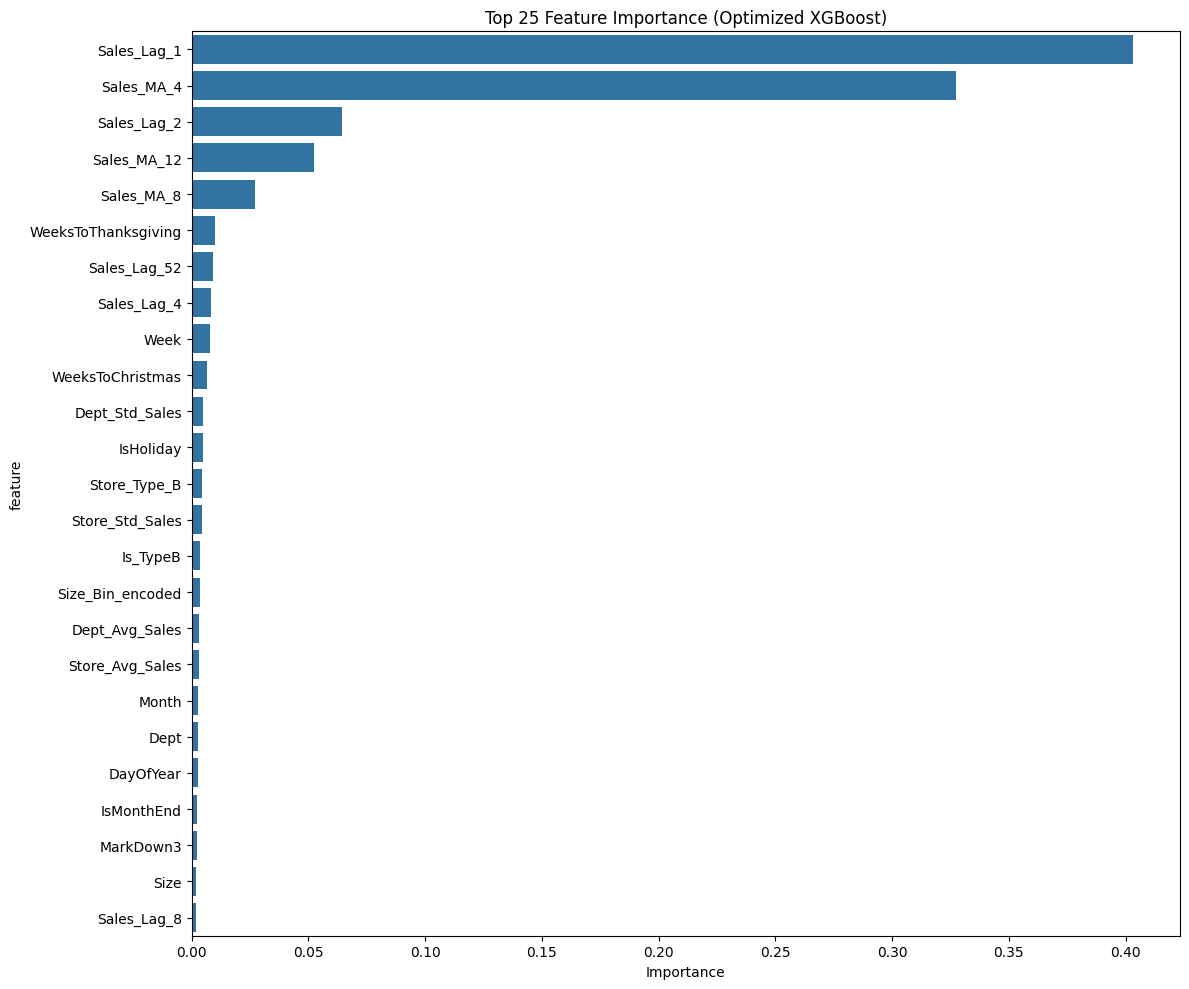

Generating SHAP explanations...


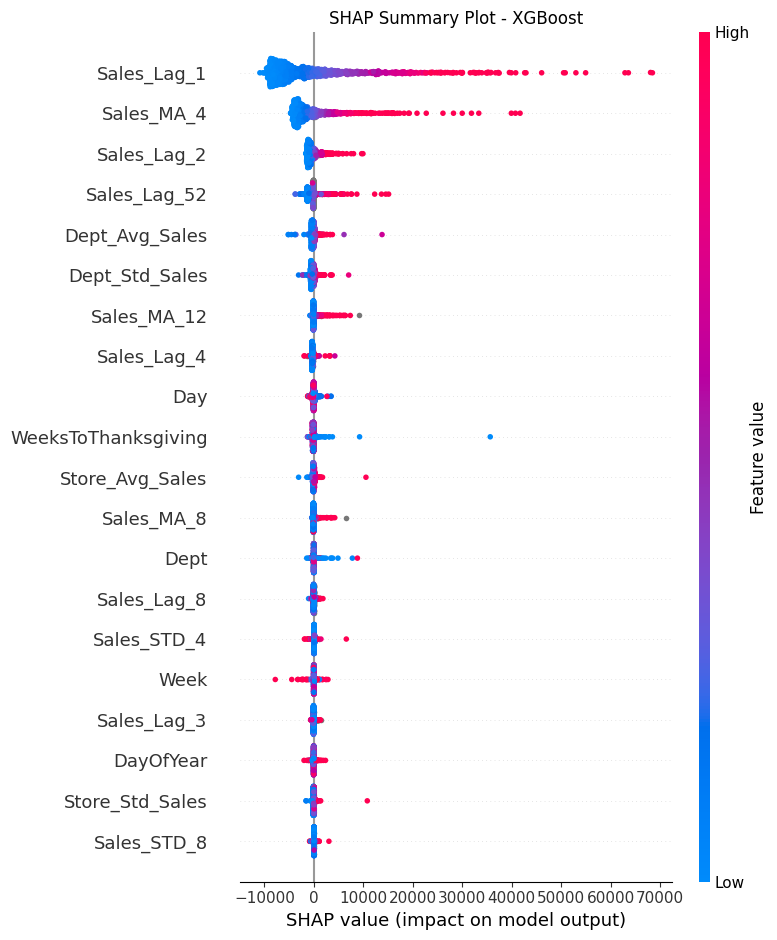

In [15]:
# Feature importance analysis
feature_importance_optimized = pd.DataFrame({
    'feature': X_train.columns,
    'importance': optimized_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(data=feature_importance_optimized.head(25), x='importance', y='feature')
plt.title('Top 25 Feature Importance (Optimized XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# SHAP analysis
print("Generating SHAP explanations...")
explainer = shap.TreeExplainer(optimized_model)
shap_values = explainer.shap_values(X_train.sample(1000, random_state=42))  # Sample for speed

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train.sample(1000, random_state=42), show=False)
plt.title('SHAP Summary Plot - XGBoost')
plt.tight_layout()
plt.show()

## Predictions and Residual Analysis

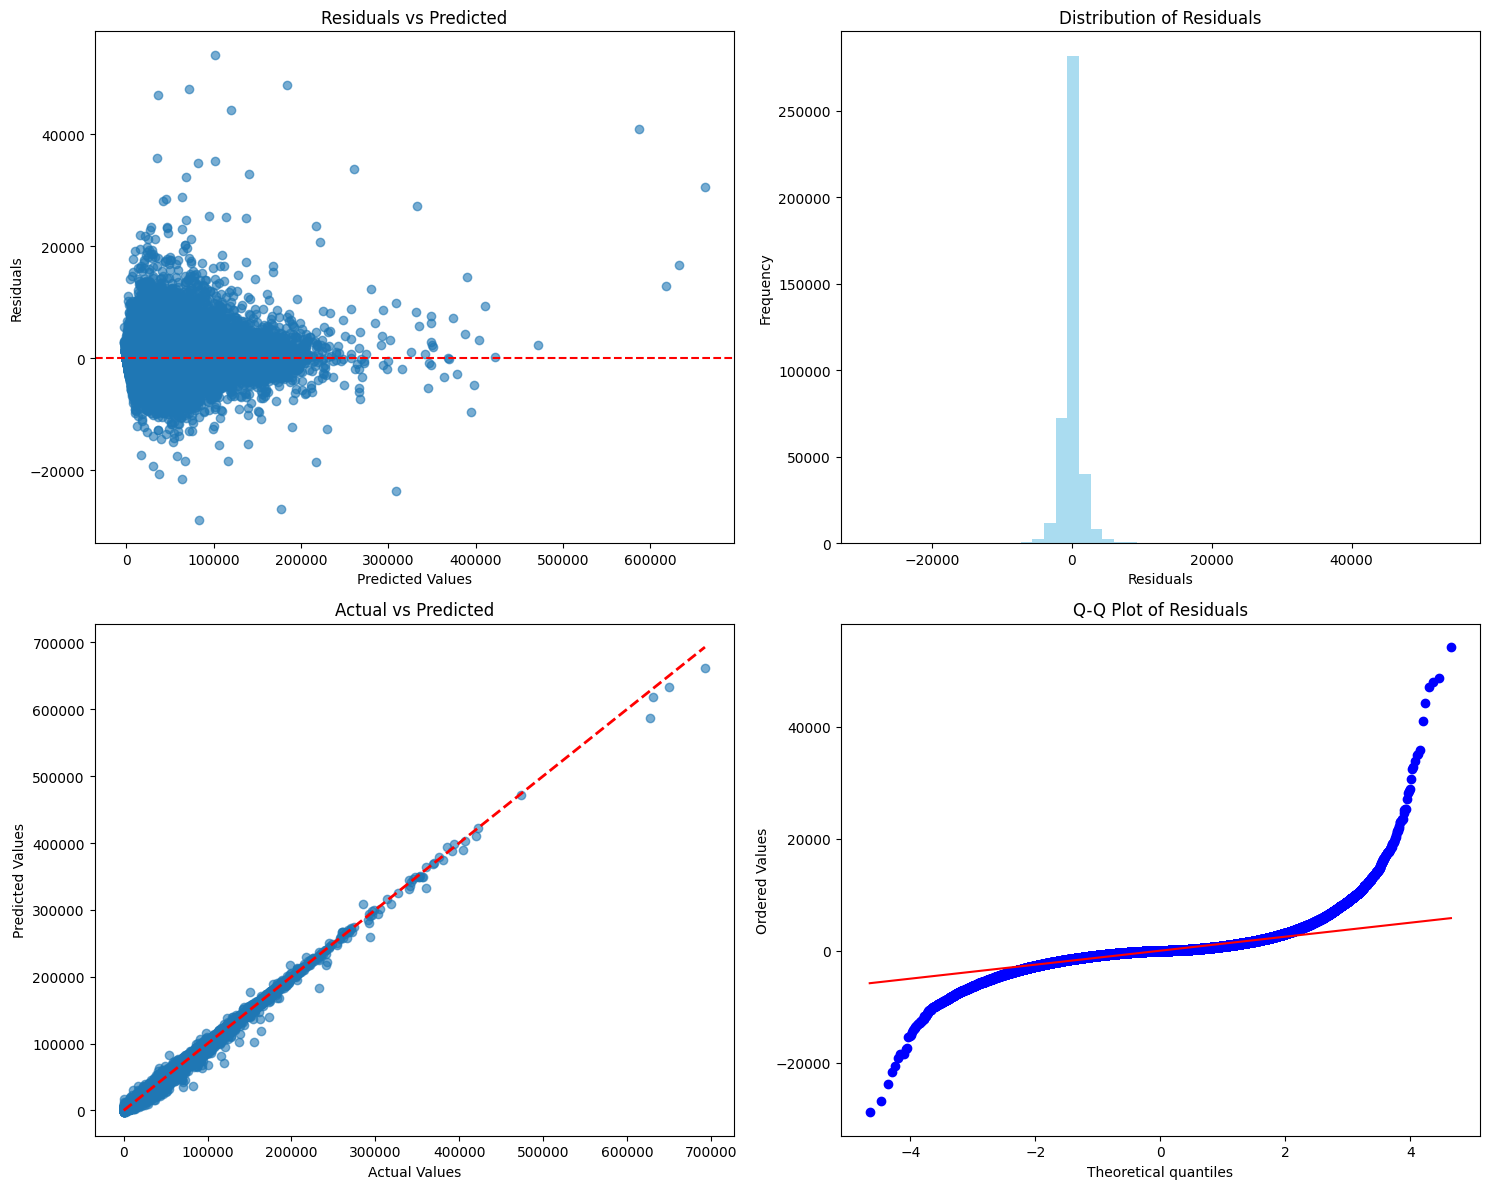

In [16]:
# Calculate residuals
residuals = y_train - y_pred_optimized

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Predicted
axes[0, 0].scatter(y_pred_optimized, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted')

# Residuals distribution
axes[0, 1].hist(residuals, bins=50, alpha=0.7, color='skyblue')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Residuals')

# Actual vs Predicted
axes[1, 0].scatter(y_train, y_pred_optimized, alpha=0.6)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].set_title('Actual vs Predicted')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

## Create Final Pipeline

In [17]:
class XGBoostPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessing_pipeline, model_params):
        self.preprocessing_pipeline = preprocessing_pipeline
        self.model_params = model_params
        self.model = None
        self.is_fitted = False
        self.feature_names_ = None # To store final feature names

    def _apply_preprocessing(self, X_raw):
        """Apply all preprocessing steps to raw data."""
        # Apply initial preprocessing pipeline
        X_processed = self.preprocessing_pipeline.transform(X_raw)

        # Drop the original 'Size_Bin' column
        if 'Size_Bin' in X_processed.columns:
          X_processed = X_processed.drop('Size_Bin', axis=1)

        # One-hot encode the 'Type' column
        if 'Type' in X_processed.columns:
          X_processed = pd.get_dummies(X_processed, columns=['Type'], prefix='Store_Type')

        # Drop the 'Date' column as it's not a feature for the model
        if 'Date' in X_processed.columns:
            X_processed = X_processed.drop('Date', axis=1)

        # Ensure the order and presence of columns match the training data features
        if self.feature_names_ is not None:
             # Reindex to ensure consistent column order and handle missing dummy columns
            X_processed = X_processed.reindex(columns=self.feature_names_, fill_value=0)


        return X_processed


    def fit(self, X_raw, y=None):
        """Fit the complete pipeline"""
        # Preprocess data
        X_processed = self._apply_preprocessing(X_raw)

        # Store the final feature names after preprocessing
        self.feature_names_ = X_processed.columns.tolist()

        # Create and fit model
        self.model = xgb.XGBRegressor(
                    tree_method='gpu_hist',
                    predictor='gpu_predictor',
                    **self.model_params
                )
        self.model.fit(X_processed, y)

        self.is_fitted = True
        return self

    def predict(self, X_raw):
        """Make predictions on raw data"""
        if not self.is_fitted:
            raise ValueError("Pipeline must be fitted before making predictions")

        # Preprocess data
        X_processed = self._apply_preprocessing(X_raw)

        # Make predictions
        return self.model.predict(X_processed)

    def get_feature_importance(self):
        """Get feature importance"""
        if not self.is_fitted:
            raise ValueError("Pipeline must be fitted before getting feature importance")

        return pd.DataFrame({
            'feature': self.feature_names_,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

# Create final pipeline
final_pipeline = XGBoostPipeline(
    preprocessing_pipeline=loaded_pipeline,
    model_params=optimized_params
)

# Fit final pipeline
final_pipeline.fit(train_raw, y_train)

print("Final XGBoost Pipeline created and fitted successfully!")

Final XGBoost Pipeline created and fitted successfully!


## Save Final Model and Register

In [18]:
with mlflow.start_run(run_name="XGBoost_Final_Pipeline"):
    # Log final parameters
    mlflow.log_params(optimized_params)

    # Make predictions with final pipeline
    y_pred_final = final_pipeline.predict(train_raw)

    # Calculate final metrics
    train_mae_final = mean_absolute_error(y_train, y_pred_final)
    train_wmae_final = wmae(y_train, y_pred_final, train_weights)
    train_rmse_final = np.sqrt(mean_squared_error(y_train, y_pred_final))
    train_r2_final = r2_score(y_train, y_pred_final)

    # Log final metrics
    mlflow.log_metrics({
        'final_train_mae': train_mae_final,
        'final_train_wmae': train_wmae_final,
        'final_train_rmse': train_rmse_final,
        'final_train_r2': train_r2_final
    })

    # Save pipeline
    joblib.dump(final_pipeline, 'xgboost_final_pipeline.pkl')
    mlflow.log_artifact('xgboost_final_pipeline.pkl')

    # Log model with signature
    sample_input = train_raw.head(1)
    signature = mlflow.models.infer_signature(sample_input, final_pipeline.predict(sample_input))
    # mlflow.sklearn.log_model(
    #     final_pipeline,
    #     "xgboost_final_model",
    #     signature=signature,
    #     input_example=sample_input
    # )

    # Register model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/xgboost_final_model"
    # mlflow.register_model(model_uri, "XGBoost_Walmart_Sales")

    print(f"Final XGBoost Pipeline Results:")
    print(f"Train MAE: {train_mae_final:.4f}")
    print(f"Train WMAE: {train_wmae_final:.4f}")
    print(f"Train RMSE: {train_rmse_final:.4f}")
    print(f"Train R\u00b2: {train_r2_final:.4f}")

    # Get run ID for later use
    run_id = mlflow.active_run().info.run_id
    print(f"Model registered with run ID: {run_id}")

Final XGBoost Pipeline Results:
Train MAE: 104.3237
Train WMAE: 108.2611
Train RMSE: 241.7754
Train R²: 0.9999
Model registered with run ID: 409e09761c8947a39b2b5d0071327a6e
🏃 View run XGBoost_Final_Pipeline at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/3/runs/409e09761c8947a39b2b5d0071327a6e
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/3


## Generate Test Set Predictions

In [19]:
# Generate predictions for test set
test_predictions = final_pipeline.predict(test_raw)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': test_raw['Store'].astype(str) + '_' +
          test_raw['Dept'].astype(str) + '_' +
          test_raw['Date'].astype(str),
    'Weekly_Sales': test_predictions
})

# Save submission
submission.to_csv('xgboost_submission.csv', index=False)

print(f"Test predictions generated successfully!")
print(f"Submission shape: {submission.shape}")
print(f"Prediction statistics:")
print(f"Mean: {test_predictions.mean():.2f}")
print(f"Std: {test_predictions.std():.2f}")
print(f"Min: {test_predictions.min():.2f}")
print(f"Max: {test_predictions.max():.2f}")

# Display first few predictions
print("\nFirst 10 predictions:")
print(submission.head(10))

Test predictions generated successfully!
Submission shape: (115064, 2)
Prediction statistics:
Mean: 1199.47
Std: 3247.47
Min: -6363.36
Max: 40066.74

First 10 predictions:
               Id  Weekly_Sales
0  1_1_2012-11-02    874.091797
1  1_1_2012-11-09    913.424805
2  1_1_2012-11-16    972.258789
3  1_1_2012-11-23   1278.120117
4  1_1_2012-11-30   1061.158203
5  1_1_2012-12-07    989.436523
6  1_1_2012-12-14    942.563477
7  1_1_2012-12-21    679.521484
8  1_1_2012-12-28    880.418945
9  1_1_2013-01-04    985.286133


## Model Summary and Comparison

In [20]:
print("=" * 60)
print("XGBoost Model Training Summary")
print("=" * 60)

print(f"\nDataset Information:")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Features: {X_train.shape[1]}")
print(f"Holiday weeks in training: {(train_weights == 5).sum()}")

print(f"\nModel Performance:")
print(f"Final Train MAE: {train_mae_final:.4f}")
print(f"Final Train WMAE: {train_wmae_final:.4f}")
print(f"Final Train RMSE: {train_rmse_final:.4f}")
print(f"Final Train R\u00b2: {train_r2_final:.4f}")

print(f"\nBest Hyperparameters:")
for param, value in optimized_params.items():
    if param not in ['random_state', 'n_jobs']:
        print(f"{param}: {value}")

print(f"\nTop 5 Most Important Features:")
feature_importance_final = final_pipeline.get_feature_importance()
print(feature_importance_final.head().to_string(index=False))

print(f"\nFiles Generated:")
print(f"- xgboost_final_pipeline.pkl")
print(f"- xgboost_submission.csv")

print("\nModel registered in MLflow Model Registry as 'XGBoost_Walmart_Sales'")
print("Training completed successfully!")

XGBoost Model Training Summary

Dataset Information:
Training samples: 421,570
Test samples: 115,064
Features: 63
Holiday weeks in training: 29661

Model Performance:
Final Train MAE: 104.3237
Final Train WMAE: 108.2611
Final Train RMSE: 241.7754
Final Train R²: 0.9999

Best Hyperparameters:
n_estimators: 772
max_depth: 10
learning_rate: 0.054151283475118786
subsample: 0.8508906557730747
colsample_bytree: 0.6562897109087916
reg_alpha: 0.4411816203865849
reg_lambda: 5.309509761050698
min_child_weight: 8
gamma: 3.851785701926843

Top 5 Most Important Features:
            feature  importance
       Weekly_Sales    0.655982
         Sales_MA_4    0.148426
        Sales_Lag_1    0.102944
WeeksToThanksgiving    0.013603
           Is_TypeB    0.006577

Files Generated:
- xgboost_final_pipeline.pkl
- xgboost_submission.csv

Model registered in MLflow Model Registry as 'XGBoost_Walmart_Sales'
Training completed successfully!
